In [10]:
# Dependencies
import config
import tweepy
import numpy as np
import pandas as pd
import datetime as datetime
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Twitter API Keys
from config import (consumer_key,
                    consumer_secret,
                    access_token,
                    access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [11]:
# Twitter accounts that we are going to analyze
target_user = ("@BBC", "@CBS", "@CNN", "@FoxNews", "@nytimes")

# Create an empty list for dictionaries of sentiment results
results_list = []

# List for holding sentiments
sentiments = []


In [12]:
#Loop through each target user

for user in target_user:
    
    #Initialize empty lists to hold the sentiment results
    compound_list = []
    positive_list = []
    negative_list = []
    neutral_list = []
        
    #Initialize the counter variable
    counter = 1
    
    # Variable for max_id
    oldest_tweet = None
    
     # Loop through 5 pages of tweets (total 100 tweets)
    for x in range(1, 6):

        # Get all tweets from home feed using Tweepy
        public_tweets = api.user_timeline(user, max_id = oldest_tweet)

        # Loop through all tweets
        for tweet in public_tweets:

            # Run Vader Analysis on each tweet
            results = analyzer.polarity_scores(tweet["text"])
            compound = results["compound"]
            pos = results["pos"]
            neu = results["neu"]
            neg = results["neg"]
            tweet_date = tweet["created_at"]
            
            # Get Tweet ID, subtract 1, and assign to oldest_tweet
            oldest_tweet = tweet['id'] - 1
        

            # Add each value to the appropriate list
            compound_list.append(compound)
            positive_list.append(pos)
            negative_list.append(neg)
            neutral_list.append(neu)
           
                  
            #Add sentiments for each tweet into a list
            sentiments.append({"Username": user,
                               "Date": tweet_date, 
                               "Compound": compound,
                               "Positive": pos,
                               "Negative": neu,
                               "Neutral": neg,
                               "Tweets Ago": counter})
    
            #Add to counter 
            counter += 1
  
print(f"Finished getting results from Twitter.")
    
    

Finished getting results from Twitter.


In [13]:
# Create DataFrame from Results List
results_df = pd.DataFrame.from_dict(sentiments).set_index('Username').round(3)
results_df.head(10)

,Compound,Date,Negative,Neutral,Positive,Tweets Ago
Username,,,,,,
@BBC,-0.128,Mon Oct 01 19:00:01 +0000 2018,0.919,0.081,0.000,1
@BBC,0.000,Mon Oct 01 17:16:04 +0000 2018,1.000,0.000,0.000,2
@BBC,0.751,Mon Oct 01 16:05:44 +0000 2018,0.738,0.000,0.262,3
@BBC,0.000,Mon Oct 01 15:48:02 +0000 2018,1.000,0.000,0.000,4
@BBC,0.000,Mon Oct 01 15:00:02 +0000 2018,1.000,0.000,0.000,5
@BBC,0.000,Mon Oct 01 14:01:07 +0000 2018,1.000,0.000,0.000,6
@BBC,0.000,Mon Oct 01 13:04:26 +0000 2018,1.000,0.000,0.000,7
@BBC,0.746,Mon Oct 01 13:03:06 +0000 2018,0.689,0.000,0.311,8
@BBC,0.128,Mon Oct 01 12:33:03 +0000 2018,0.642,0.166,0.193,9


(100, 0)

<Figure size 432x288 with 0 Axes>

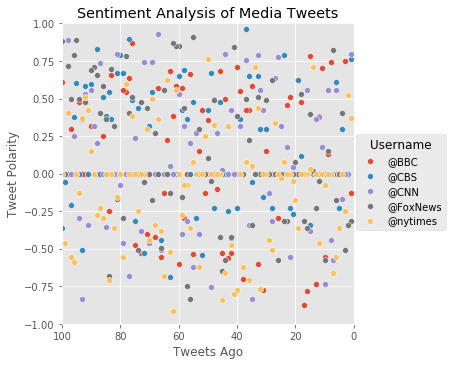

In [14]:
#Now place all of the polarity plot points for all of the organizations on one plot

plt.clf()

results_df_flat = results_df.reset_index()

grid = sns.pairplot(x_vars=["Tweets Ago"], y_vars=["Compound"], data=results_df_flat, hue="Username", size=5)

plt.title("Sentiment Analysis of Media Tweets")
plt.ylabel("Tweet Polarity")
plt.ylim([-1.0,1.0]) 
plt.xlim([100, 0])




In [15]:
#Function for plotting the Twitter sentiment results
def sentiment_plot(username):
    
    plt.clf()
    
    x_vals = results_df.loc[username, "Tweets Ago"]
    y_vals = results_df.loc[username, "Compound"]
    plt.plot(x_vals, y_vals, marker="o", linewidth=0.5, alpha=0.8)

    # # Incorporate the other graph properties
    now = datetime.datetime.now()
    asofdate = now.strftime("%m/%d/%y")
    plt.title(f"Sentiment Analysis of Tweets As Of {asofdate}")
    plt.ylim([-1.0,1.0]) 
    plt.xlim([100, 0])
    plt.ylabel("Tweet Polarity")
    plt.xlabel("Tweets Ago")
    legend = plt.legend({username}, title="Tweets", bbox_to_anchor=(1.30, 1), shadow=True)
   
    #Save the figure
    figname=f"Images/Tweet Analysis for {username}.png"
    plt.savefig(fname=figname, bbox_extra_artists=(legend))
    

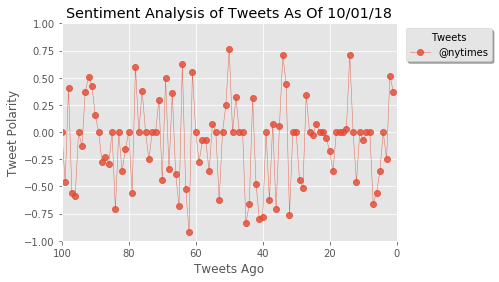

In [16]:
#Call the sentiment plotting function for each news organization
# to get a separate plot for each one.

for name in target_user:
    sentiment_plot(name)



In [17]:
#Aggregate the overall sentiments last 100 tweets for each news organization 

#Get the mean of the compound score from the dataframe

score_groupby = results_df.groupby(['Username']).mean()
                                               
score_groupby



,Compound,Negative,Neutral,Positive,Tweets Ago
Username,,,,,
@BBC,0.08818,0.83939,0.06311,0.09748,50.5
@CBS,0.14243,0.87583,0.03422,0.08996,50.5
@CNN,0.08279,0.86048,0.05411,0.08544,50.5
@FoxNews,0.13703,0.80787,0.06190,0.13022,50.5
@nytimes,-0.08602,0.85788,0.08727,0.05489,50.5


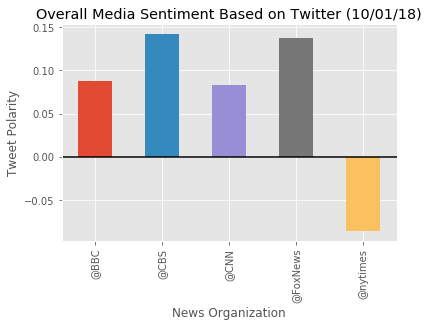

In [18]:
#Create a bar plot for the Compound score of each news organization

#Put the groupby into a regular dataframe by resetting the index

compound_score_df = score_groupby.reset_index()
compound_score_df

#Get the M/D/Y format for plot title
now = datetime.datetime.now()
asofdate = now.strftime("%m/%d/%y")

#Create the bar plot

plt.figure()

ax2 = score_groupby['Compound'].plot.bar(title=f"Overall Media Sentiment Based on Twitter ({asofdate})")
                                        
ax2.set_ylabel("Tweet Polarity")
ax2.set_xlabel("News Organization")

plt.axhline(0, color='k')